# Fraudulent Transactions Prediction

### Predict fraudlent transactions

- import dependencies
- import dataset
- explore data and visualize
- perform machine learning
- test model on testing set

In [0]:
# Install Kaggle
! pip install -q kaggle

# import function to upload files (upload kaggle.json)
from google.colab import files

In [0]:
files.upload()

In [5]:
# Create directory for kaggle.json
# Copy and Set permission
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
%mkdir train
%mkdir test

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! kaggle competitions download -c ieee-fraud-detection

 88% 46.0M/52.5M [00:00<00:00, 67.6MB/s]
100% 52.5M/52.5M [00:00<00:00, 107MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 98.6MB/s]
 85% 40.0M/47.3M [00:00<00:00, 79.2MB/s]
100% 47.3M/47.3M [00:00<00:00, 136MB/s] 
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 97.9MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 160MB/s]


In [7]:
! unzip train_transaction.csv.zip -d train
! unzip train_identity.csv.zip -d train
! unzip test_transaction.csv.zip -d test
! unzip test_identity.csv.zip -d test

Archive:  train_transaction.csv.zip
  inflating: train/train_transaction.csv  
Archive:  train_identity.csv.zip
  inflating: train/train_identity.csv  
Archive:  test_transaction.csv.zip
  inflating: test/test_transaction.csv  
Archive:  test_identity.csv.zip
  inflating: test/test_identity.csv  


In [0]:
import random
from typing import List
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# Machine Learning
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [0]:
transaction_features = ['TransactionID', 'isFraud', 'TransactionAmt', 'P_emaildomain', 'R_emaildomain']
identity_features = ['TransactionID', 'DeviceType']
train_files = ['train/train_transaction.csv', 'train/train_identity.csv']
test_files = ['test/test_transaction.csv', 'test/test_identity.csv']

In [0]:
def get_transaction_dataframe(file_name: str, transaction_features: List[str]) -> "DataFrame":
    df = pd.read_csv(file_name, usecols=transaction_features, low_memory=False)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [0]:
def get_identity_dataframe(file_name: str, identity_features: List[str]) -> "DataFrame":
    df = pd.read_csv(file_name, usecols=identity_features, low_memory=False)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [9]:
# Merging 2 datasource for training data
df_train_transaction = get_transaction_dataframe(train_files[0], transaction_features)
df_train_identity = get_identity_dataframe(train_files[1], identity_features)
df_full = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='inner')
df_full.head()

,TransactionID,isFraud,TransactionAmt,P_emaildomain,R_emaildomain,DeviceType
0,3085705,0,25.000,gmail.com,gmail.com,mobile
1,3064029,0,450.000,anonymous.com,aol.com,desktop
2,3461156,0,28.158,gmail.com,gmail.com,desktop
3,3158592,1,125.000,gmail.com,gmail.com,mobile
4,3330243,0,15.000,NaN,anonymous.com,desktop


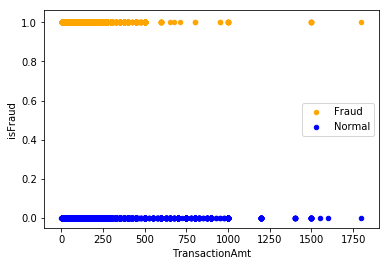

In [12]:
frauds = df_full.loc[df_full['isFraud'] == 1]
non_frauds = df_full.loc[df_full['isFraud'] == 0]
ax = frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)

plt.show()

P_emaildomain
gmail.com        54140
hotmail.com      25782
anonymous.com    17840
yahoo.com        11667
aol.com           4306
outlook.com       2346
comcast.net       2196
yahoo.com.mx      1182
msn.com           1069
icloud.com        1022
Name: P_emaildomain, dtype: int64

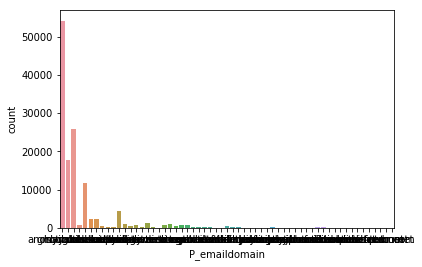

In [13]:
sns.countplot(x='P_emaildomain', data=df_full)
df_full[['P_emaildomain']].groupby(['P_emaildomain'])['P_emaildomain'].count().nlargest(10)

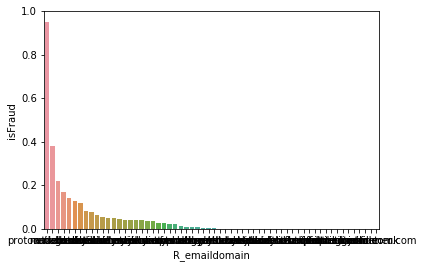

In [14]:
r_email_domain_to_is_fraud = df_full[['R_emaildomain','isFraud']].groupby(['R_emaildomain'], as_index=False).mean().sort_values(by='isFraud', ascending=False)
sns.barplot(x="R_emaildomain", y="isFraud", data=r_email_domain_to_is_fraud)

In [15]:
# R consist of all email domains in P
r_email_domain_mapping = {}
r_email_domain_to_is_fraud = df_full[['R_emaildomain','isFraud']].groupby(['R_emaildomain'], as_index=False).mean().sort_values(by='isFraud', ascending=False)
r_emaildomain_isfraud_map = dict(zip(r_email_domain_to_is_fraud['R_emaildomain'], r_email_domain_to_is_fraud['isFraud']))
r_emaildomain_isfraud_map[np.nan] = 0
r_emaildomain_isfraud_map

{'aim.com': 0.027777777777777776,
 'anonymous.com': 0.029136001613065832,
 'aol.com': 0.03488689016080676,
 'att.net': 0.0,
 'bellsouth.net': 0.00477326968973747,
 'cableone.net': 0.0,
 'centurylink.net': 0.0,
 'cfl.rr.com': 0.0,
 'charter.net': 0.03968253968253968,
 'comcast.net': 0.011602209944751382,
 'cox.net': 0.024070021881838075,
 'earthlink.net': 0.0759493670886076,
 'embarqmail.com': 0.0,
 'frontier.com': 0.0,
 'frontiernet.net': 0.0,
 'gmail': 0.0,
 'gmail.com': 0.1203362443036366,
 'gmx.de': 0.0,
 'hotmail.co.uk': 0.0,
 'hotmail.com': 0.08156821996642954,
 'hotmail.de': 0.0,
 'hotmail.es': 0.06273062730627306,
 'hotmail.fr': 0.0,
 'icloud.com': 0.13018181818181818,
 'juno.com': 0.0,
 'live.com': 0.051075268817204304,
 'live.com.mx': 0.05606060606060606,
 'live.fr': 0.0,
 'mac.com': 0.009302325581395349,
 'mail.com': 0.38016528925619836,
 'me.com': 0.020257826887661142,
 'msn.com': 0.0011904761904761906,
 nan: 0,
 'netzero.com': 0.0,
 'netzero.net': 0.2222222222222222,
 'opto

In [16]:
# Data cleaning
device_mapping = {'desktop': 2, 'mobile': 1, np.nan: 0}
df_full['DeviceType'] = df_full['DeviceType'].map(device_mapping)
df_full['P_emaildomain'] = df_full['P_emaildomain'].map(r_emaildomain_isfraud_map)
df_full['R_emaildomain'] = df_full['R_emaildomain'].map(r_emaildomain_isfraud_map)
df_full.head()

,TransactionID,isFraud,TransactionAmt,P_emaildomain,R_emaildomain,DeviceType
0,3085705,0,25.000,0.120336,0.120336,1
1,3064029,0,450.000,0.029136,0.034887,2
2,3461156,0,28.158,0.120336,0.120336,2
3,3158592,1,125.000,0.120336,0.120336,1
4,3330243,0,15.000,0.000000,0.029136,2


In [17]:
x = df_full.drop(columns=['isFraud'])
y = df_full['isFraud']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(100963, 43270, 100963, 43270)

In [18]:
X_train.head(), X_test.head(), Y_train.head()

(        TransactionID  TransactionAmt  P_emaildomain  R_emaildomain  DeviceType
 47579         3377207          40.602       0.120336       0.120336           1
 102952        3383546         122.169       0.120336       0.120336           2
 45904         3577418         150.000       0.051438       0.120336           1
 85994         3009134         400.000       0.029136       0.029136           2
 106665        3040000          25.000       0.029136       0.120336           0,
         TransactionID  TransactionAmt  P_emaildomain  R_emaildomain  DeviceType
 39265         3084692           100.0       0.051438       0.081568           1
 64382         3199693           200.0       0.000000       0.051438           2
 93727         3331373            50.0       0.120336       0.130182           1
 34521         3105955           100.0       0.120336       0.029136           2
 103308        3106655           200.0       0.029136       0.029136           1,
 47579     0
 102952    0


In [19]:
log_reg = linear_model.LogisticRegression(C=1e5) # C -> Regulate against overfitting
log_reg.fit(X_train, Y_train)
print("Score: ", log_reg.score(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score:  0.9222787150450659


In [0]:
# For submission in Kaggle

test_transaction_features = ['TransactionID', 'TransactionAmt', 'P_emaildomain', 'R_emaildomain']
# Repeat process for Testing Data
df_test_transaction = get_transaction_dataframe(test_files[0], test_transaction_features)
df_test_identity = get_identity_dataframe(test_files[1], identity_features)
df_test_full = pd.merge(df_test_transaction, df_test_identity, on='TransactionID', how='outer')

# Data cleaning
device_mapping = {'desktop': 2, 'mobile': 1, np.nan: 0}
df_test_full['DeviceType'] = df_test_full['DeviceType'].map(device_mapping)
df_test_full['P_emaildomain'] = df_test_full['P_emaildomain'].map(r_emaildomain_isfraud_map)
df_test_full['R_emaildomain'] = df_test_full['R_emaildomain'].map(r_emaildomain_isfraud_map)
df_test_full.head()

submission_X_test = df_test_full.loc[:, :]
Y_pred = np.array(log_reg.predict(submission_X_test))


output = pd.DataFrame({'TransactionID': submission_X_test.TransactionID,
                       'isFraud': Y_pred})
output.to_csv('submission.csv', index=False)

In [22]:
len(Y_pred)

506691